In [164]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [165]:
import os
import zipfile

# Path ZIP dan lokasi ekstraksi
zip_path = "/home/antariksa/Desktop/Coding/gestur-abjad/dataset/dataset-bisindo-22k.zip"
extract_path = "/home/antariksa/Desktop/Coding/gestur-abjad/ekstrakted"

# Ekstraksi jika folder belum ada
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset berhasil diekstrak ke:", extract_path)


Dataset berhasil diekstrak ke: /home/antariksa/Desktop/Coding/gestur-abjad/ekstrakted


In [166]:
# Label mapping termasuk huruf Z
label_mapping = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4,
    'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9,
    'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14,
    'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19,
    'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24,
    'Z': 25
}

inv_label_mapping = {v: k for k, v in label_mapping.items()}

RANDOM_SEED = 26
PATH_DATASET = "/home/antariksa/Desktop/Coding/gestur-abjad/ekstrakted/bisindo"


In [167]:
# Create the DataFrame `df` by collecting image paths and labels
data = []
for label in label_mapping.keys():
    label_path = os.path.join(PATH_DATASET, "images", "train", label) # Assuming "train" is the subfolder for training data
    if os.path.exists(label_path):
        for fname in os.listdir(label_path):
            full_path = os.path.join(label_path, fname)
            if os.path.isfile(full_path):
                data.append({
                    "label": label_mapping[label],  # Store numerical label
                    "full_path": full_path
                })
    else:
        print(f"Warning: {label_path} not found, skipping.")

df = pd.DataFrame(data)

print(f"Total data points found: {len(df)}")

df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=RANDOM_SEED)

Total data points found: 9169


In [168]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Mean & std
DATA_MEAN = (0.5,)
DATA_STD = (0.5,)

# Transformasi training (dengan rotasi fixed)
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.RandomChoice([  # rotasi tanpa black spot
        transforms.Lambda(lambda img: img),
        transforms.Lambda(lambda img: img.rotate(90, expand=True)),
        transforms.Lambda(lambda img: img.rotate(180, expand=True)),
        transforms.Lambda(lambda img: img.rotate(270, expand=True))
    ]),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)
])

# Transformasi validasi (tanpa augmentasi)
val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)
])

# Fungsi untuk menampilkan perbandingan
def show_augmentation(img_path, transform):
    original = Image.open(img_path).convert("RGB")
    augmented = transform(original)

    # Kembalikan dari tensor ke PIL untuk visualisasi
    augmented = transforms.ToPILImage()(augmented * 0.5 + 0.5)  # unnormalize

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(augmented)
    ax[1].set_title("Augmented")
    ax[1].axis("off")

    plt.show()

In [169]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['full_path']
        label = self.data.iloc[idx]['label']
        image = Image.open(img_path).convert('L')
        return self.transform(image), torch.tensor(label).long()
    

In [170]:
train_loader = DataLoader(CustomDataset(df_train, train_transform), batch_size=64, shuffle=True)
val_loader = DataLoader(CustomDataset(df_val, val_transform), batch_size=64, shuffle=False)

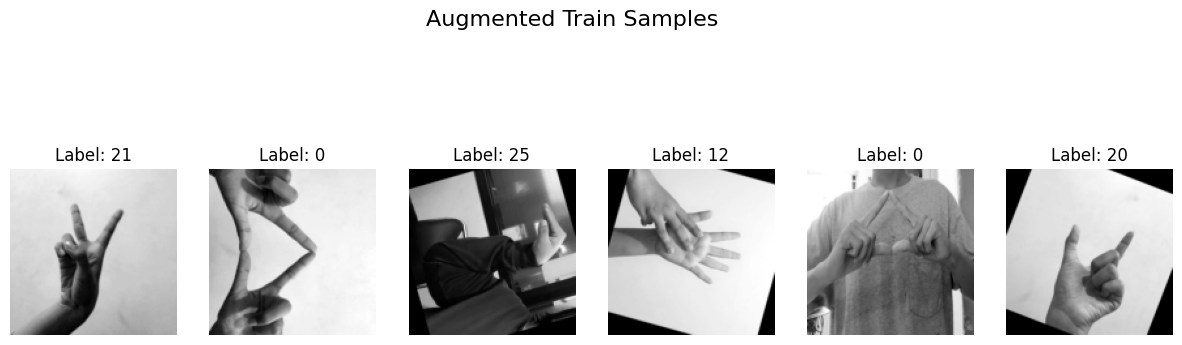

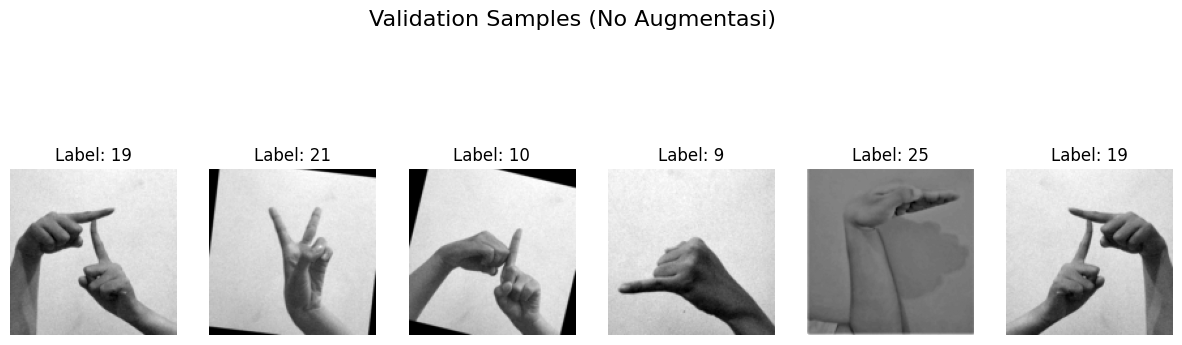

In [171]:
import matplotlib.pyplot as plt
import numpy as np

def imshow_tensor(img_tensor):
    """Unnormalize dan tampilkan gambar dari tensor"""
    img_tensor = img_tensor * 0.5 + 0.5  # unnormalize (karena normalisasi mean=0.5, std=0.5)
    img_numpy = img_tensor.numpy().transpose((1, 2, 0))  # ubah channel untuk Matplotlib
    plt.imshow(img_numpy, cmap='gray')
    plt.axis('off')

def show_batch_samples(dataloader, title, n_images=6):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)  # ambil batch pertama
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        imshow_tensor(images[i])
        plt.title(f"Label: {labels[i].item()}")
    plt.show()

# Tampilkan beberapa sampel augmentasi dari train_dataset
show_batch_samples(train_loader, "Augmented Train Samples")

# Tampilkan beberapa sampel augmentasi dari val_dataset
show_batch_samples(val_loader, "Validation Samples (No Augmentasi)")


In [172]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout2d(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # PERBAIKAN DI SINI: Menggunakan ukuran input yang benar
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        # Bentuk x di sini sebelum flatten adalah (batch_size, 128, 16, 16)
        return self.classifier(x)

In [173]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Asumsi: df_val adalah DataFrame validasi Anda yang sudah didefinisikan
# import pandas as pd
# df_val = pd.read_csv(...) # Contoh

def train_model(model, train_loader, val_loader, epochs, device):
    # Lists untuk menyimpan history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    print("Memulai Training...")
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, train_correct, total_train = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        # Validation Phase
        model.eval()
        val_loss, val_correct, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                total_val += labels.size(0)

        # Hitung rata-rata loss dan akurasi untuk epoch ini
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = train_correct / total_train
        val_acc = val_correct / total_val # Menggunakan total_val untuk konsistensi

        # Simpan ke history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    print("Training Selesai!")
    return history

def plot_history(history):
    # Plotting Training & Validation Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plotting Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# --- CONTOH PENGGUNAAN ---
# Misalkan model, train_loader, val_loader, dll. sudah Anda siapkan
# epochs = 25
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
# # Panggil fungsi training dan simpan history-nya
# training_history = train_model(model, train_loader, val_loader, epochs, device)
#
# # Panggil fungsi plotting
# plot_history(training_history)

In [174]:
!nvidia-smi

4790.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Sat Aug 30 20:03:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   60C    P8              9W /   60W |    2657MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [182]:
model = CNN(num_classes=26)

EPOCH = 70 # ubah epoch berdasarkan berapa kali model ingin di training
DEVICE = 'cuda' # 'cuda' apabila bisa menggunakan gpu dan 'cpu' apabila ingin menggunakan cpu

training_history = train_model(model, train_loader, val_loader, device=DEVICE, epochs=EPOCH)
    
nama_file = f"cnn_handsign_model_{EPOCH}_epoch.pth"
torch.save(model.state_dict(), nama_file)

print(f"Model berhasil disimpan sebagai: {nama_file}") # Ubah string untuk menentukan apa nama model yang akan di simpan

Memulai Training...


Epoch 1/70 | Train Loss: 3.2402 | Val Loss: 3.1433 | Train Acc: 6.49% | Val Acc: 12.98%


Epoch 2/70 | Train Loss: 3.0798 | Val Loss: 2.8882 | Train Acc: 10.40% | Val Acc: 22.74%


Epoch 3/70 | Train Loss: 2.8347 | Val Loss: 2.5013 | Train Acc: 18.01% | Val Acc: 40.95%


Epoch 4/70 | Train Loss: 2.5682 | Val Loss: 2.0858 | Train Acc: 26.13% | Val Acc: 56.32%


Epoch 5/70 | Train Loss: 2.2701 | Val Loss: 1.7669 | Train Acc: 35.68% | Val Acc: 62.10%


Epoch 6/70 | Train Loss: 2.0858 | Val Loss: 1.5546 | Train Acc: 41.05% | Val Acc: 65.70%


Epoch 7/70 | Train Loss: 1.9197 | Val Loss: 1.3794 | Train Acc: 45.64% | Val Acc: 67.23%


Epoch 8/70 | Train Loss: 1.8049 | Val Loss: 1.3060 | Train Acc: 49.52% | Val Acc: 68.76%


Epoch 9/70 | Train Loss: 1.7153 | Val Loss: 1.2327 | Train Acc: 51.72% | Val Acc: 69.25%


Epoch 10/70 | Train Loss: 1.6622 | Val Loss: 1.1897 | Train Acc: 52.88% | Val Acc: 69.74%


Epoch 11/70 | Train Loss: 1.5974 | Val Loss: 1.1389 | Train Acc: 54.63% | Val Acc: 71.10%


Epoch 12/70 | Train Loss: 1.5494 | Val Loss: 1.1247 | Train Acc: 56.32% | Val Acc: 70.39%


Epoch 13/70 | Train Loss: 1.5102 | Val Loss: 1.0946 | Train Acc: 57.59% | Val Acc: 71.76%


Epoch 14/70 | Train Loss: 1.4611 | Val Loss: 1.0757 | Train Acc: 58.10% | Val Acc: 71.97%


Epoch 15/70 | Train Loss: 1.4328 | Val Loss: 1.0506 | Train Acc: 59.17% | Val Acc: 71.81%


Epoch 16/70 | Train Loss: 1.4111 | Val Loss: 1.0455 | Train Acc: 59.95% | Val Acc: 71.48%


Epoch 17/70 | Train Loss: 1.3824 | Val Loss: 1.0352 | Train Acc: 60.98% | Val Acc: 71.86%


Epoch 18/70 | Train Loss: 1.3823 | Val Loss: 1.0181 | Train Acc: 60.40% | Val Acc: 72.03%


Epoch 19/70 | Train Loss: 1.3408 | Val Loss: 1.0224 | Train Acc: 61.65% | Val Acc: 72.14%


Epoch 20/70 | Train Loss: 1.3250 | Val Loss: 1.0084 | Train Acc: 61.69% | Val Acc: 72.57%


Epoch 21/70 | Train Loss: 1.2876 | Val Loss: 1.0033 | Train Acc: 62.67% | Val Acc: 72.25%


Epoch 22/70 | Train Loss: 1.2995 | Val Loss: 0.9956 | Train Acc: 63.26% | Val Acc: 72.52%


Epoch 23/70 | Train Loss: 1.2701 | Val Loss: 0.9825 | Train Acc: 63.90% | Val Acc: 72.96%


Epoch 24/70 | Train Loss: 1.2540 | Val Loss: 0.9760 | Train Acc: 63.80% | Val Acc: 72.96%


Epoch 25/70 | Train Loss: 1.2527 | Val Loss: 0.9739 | Train Acc: 64.36% | Val Acc: 72.41%


Epoch 26/70 | Train Loss: 1.2350 | Val Loss: 0.9690 | Train Acc: 64.14% | Val Acc: 73.17%


Epoch 27/70 | Train Loss: 1.2336 | Val Loss: 0.9645 | Train Acc: 64.39% | Val Acc: 73.17%


Epoch 28/70 | Train Loss: 1.2059 | Val Loss: 0.9682 | Train Acc: 64.84% | Val Acc: 72.68%


Epoch 29/70 | Train Loss: 1.2106 | Val Loss: 0.9643 | Train Acc: 65.06% | Val Acc: 73.06%


Epoch 30/70 | Train Loss: 1.1922 | Val Loss: 0.9510 | Train Acc: 65.97% | Val Acc: 73.34%


Epoch 31/70 | Train Loss: 1.1779 | Val Loss: 0.9485 | Train Acc: 65.73% | Val Acc: 73.28%


Epoch 32/70 | Train Loss: 1.1874 | Val Loss: 0.9429 | Train Acc: 65.78% | Val Acc: 73.45%


Epoch 33/70 | Train Loss: 1.1653 | Val Loss: 0.9420 | Train Acc: 66.45% | Val Acc: 73.50%


Epoch 34/70 | Train Loss: 1.1561 | Val Loss: 0.9488 | Train Acc: 66.86% | Val Acc: 73.88%


Epoch 35/70 | Train Loss: 1.1550 | Val Loss: 0.9342 | Train Acc: 66.49% | Val Acc: 74.70%


Epoch 36/70 | Train Loss: 1.1373 | Val Loss: 0.9221 | Train Acc: 67.23% | Val Acc: 74.32%


Epoch 37/70 | Train Loss: 1.1345 | Val Loss: 0.9300 | Train Acc: 67.23% | Val Acc: 74.15%


Epoch 38/70 | Train Loss: 1.1350 | Val Loss: 0.9161 | Train Acc: 66.84% | Val Acc: 74.37%


Epoch 39/70 | Train Loss: 1.1284 | Val Loss: 0.9260 | Train Acc: 66.71% | Val Acc: 73.77%


Epoch 40/70 | Train Loss: 1.1156 | Val Loss: 0.9248 | Train Acc: 67.47% | Val Acc: 73.61%


Epoch 41/70 | Train Loss: 1.0944 | Val Loss: 0.9117 | Train Acc: 68.17% | Val Acc: 74.32%


Epoch 42/70 | Train Loss: 1.1022 | Val Loss: 0.9264 | Train Acc: 67.62% | Val Acc: 73.99%


Epoch 43/70 | Train Loss: 1.0954 | Val Loss: 0.9091 | Train Acc: 68.15% | Val Acc: 74.10%


Epoch 44/70 | Train Loss: 1.0823 | Val Loss: 0.9186 | Train Acc: 68.04% | Val Acc: 73.99%


Epoch 45/70 | Train Loss: 1.0814 | Val Loss: 0.9065 | Train Acc: 68.25% | Val Acc: 74.54%


Epoch 46/70 | Train Loss: 1.0696 | Val Loss: 0.9099 | Train Acc: 68.96% | Val Acc: 74.15%


Epoch 47/70 | Train Loss: 1.0584 | Val Loss: 0.9086 | Train Acc: 68.81% | Val Acc: 74.48%


Epoch 48/70 | Train Loss: 1.0745 | Val Loss: 0.9053 | Train Acc: 68.75% | Val Acc: 74.43%


Epoch 49/70 | Train Loss: 1.0605 | Val Loss: 0.8892 | Train Acc: 68.85% | Val Acc: 75.14%


Epoch 50/70 | Train Loss: 1.0593 | Val Loss: 0.9007 | Train Acc: 68.77% | Val Acc: 75.25%


Epoch 51/70 | Train Loss: 1.0494 | Val Loss: 0.8967 | Train Acc: 69.13% | Val Acc: 75.41%


Epoch 52/70 | Train Loss: 1.0452 | Val Loss: 0.9069 | Train Acc: 69.27% | Val Acc: 74.70%


Epoch 53/70 | Train Loss: 1.0384 | Val Loss: 0.8933 | Train Acc: 69.19% | Val Acc: 74.70%


Epoch 54/70 | Train Loss: 1.0386 | Val Loss: 0.9038 | Train Acc: 69.37% | Val Acc: 74.65%


Epoch 55/70 | Train Loss: 1.0313 | Val Loss: 0.9012 | Train Acc: 69.46% | Val Acc: 74.21%


Epoch 56/70 | Train Loss: 1.0263 | Val Loss: 0.8913 | Train Acc: 69.90% | Val Acc: 74.81%


Epoch 57/70 | Train Loss: 1.0131 | Val Loss: 0.8880 | Train Acc: 70.29% | Val Acc: 75.30%


Epoch 58/70 | Train Loss: 1.0157 | Val Loss: 0.8805 | Train Acc: 70.03% | Val Acc: 74.65%


Epoch 59/70 | Train Loss: 1.0078 | Val Loss: 0.8767 | Train Acc: 70.07% | Val Acc: 74.86%


Epoch 60/70 | Train Loss: 0.9915 | Val Loss: 0.8820 | Train Acc: 70.31% | Val Acc: 74.97%


Epoch 61/70 | Train Loss: 1.0051 | Val Loss: 0.8800 | Train Acc: 69.91% | Val Acc: 75.03%


Epoch 62/70 | Train Loss: 0.9937 | Val Loss: 0.8964 | Train Acc: 70.62% | Val Acc: 74.86%


Epoch 63/70 | Train Loss: 0.9910 | Val Loss: 0.8781 | Train Acc: 70.39% | Val Acc: 74.81%


Epoch 64/70 | Train Loss: 0.9808 | Val Loss: 0.8929 | Train Acc: 70.76% | Val Acc: 74.86%


Epoch 65/70 | Train Loss: 0.9801 | Val Loss: 0.8732 | Train Acc: 70.70% | Val Acc: 75.35%


Epoch 66/70 | Train Loss: 0.9785 | Val Loss: 0.8750 | Train Acc: 70.63% | Val Acc: 75.63%


Epoch 67/70 | Train Loss: 0.9842 | Val Loss: 0.8688 | Train Acc: 69.94% | Val Acc: 75.74%


Epoch 68/70 | Train Loss: 0.9847 | Val Loss: 0.8627 | Train Acc: 70.62% | Val Acc: 76.06%


Epoch 69/70 | Train Loss: 0.9664 | Val Loss: 0.8795 | Train Acc: 70.72% | Val Acc: 75.35%


Epoch 70/70 | Train Loss: 0.9631 | Val Loss: 0.8672 | Train Acc: 71.12% | Val Acc: 75.46%
Training Selesai!
Model berhasil disimpan sebagai: cnn_handsign_model_70_epoch.pth


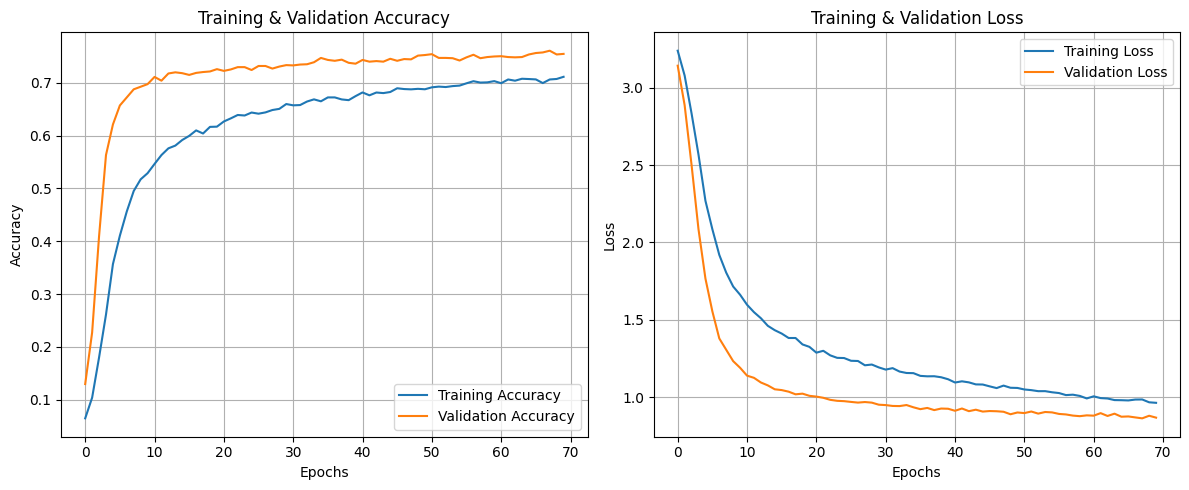

In [183]:
plot_history(training_history)

In [184]:
def evaluate(model, loader, device='cuda'):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    incorrect_samples = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device) # Move data to the correct device
            outputs = model(images)
            _, preds = outputs.max(1)
            total += labels.size(0)

            correct += (preds == labels).sum().item()
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    incorrect_samples.append((images[i].cpu(), preds[i].cpu(), labels[i].cpu()))

    print(f"Accuracy: {100 * correct / total:.2f}%")
    return incorrect_samples

In [185]:
import os
import pandas as pd
from torch.utils.data import DataLoader

# Try lowercase 'test' first
PATH_TEST = os.path.join(PATH_DATASET, "images/val")

# If lowercase 'test' doesn't exist, try uppercase 'Test' (though less likely based on previous errors)
if not os.path.exists(PATH_TEST):
    PATH_TEST = os.path.join(PATH_DATASET, "images/val")

print(f"Attempting to load test data from: {PATH_TEST}")

# Define LABELS from the keys of label_mapping
LABELS = list(label_mapping.keys())

data_test = []
if os.path.exists(PATH_TEST):
    for label in LABELS:
        label_path = os.path.join(PATH_TEST, label)
        if not os.path.exists(label_path):
            print(f"Warning: {label_path} tidak ditemukan, dilewati.")
            continue
        for fname in os.listdir(label_path):
            full_path = os.path.join(label_path, fname)
            if os.path.isfile(full_path):
                data_test.append({
                    "label": label,  # Simpan string label
                    "full_path": full_path
                })
else:
    print(f"Error: Test data directory not found at {PATH_TEST}")


df_test = pd.DataFrame(data_test)

# Only create DataLoader if test data was found
if len(df_test) > 0:
    test_loader = DataLoader(
        CustomDataset(df_test, val_transform), # Use BISINDODataset and correct paths
        batch_size=64,
        shuffle=False
    )
    print(f"Total data test: {len(df_test)}")
else:
    print("No test data found. Cannot create test_loader.")

Attempting to load test data from: /home/antariksa/Desktop/Coding/gestur-abjad/ekstrakted/bisindo/images/val
Total data test: 2301


✅ Bobot dari checkpoint 'cnn_handsign_model_70_epoch.pth' berhasil dimuat untuk evaluasi.


Evaluating: 100%|██████████| 36/36 [00:09<00:00,  3.99it/s]

Total prediksi salah: 569

Menampilkan 5 contoh prediksi yang salah:


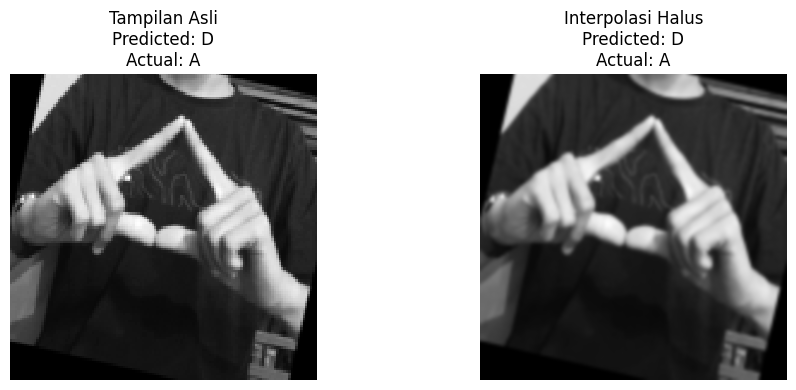

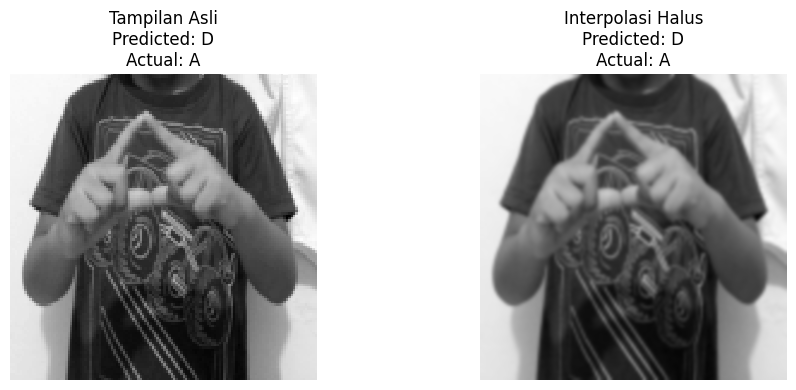

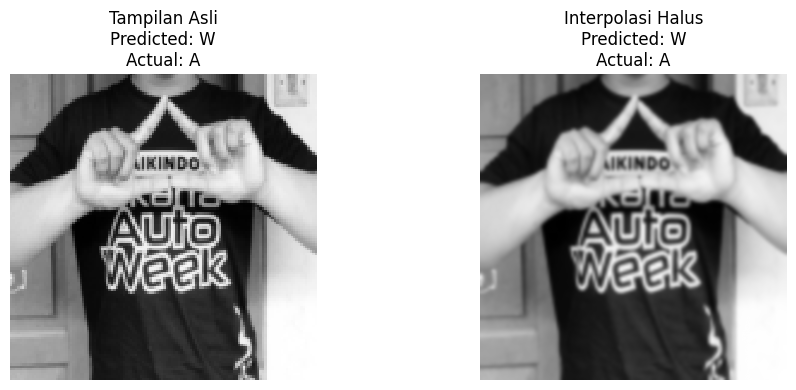

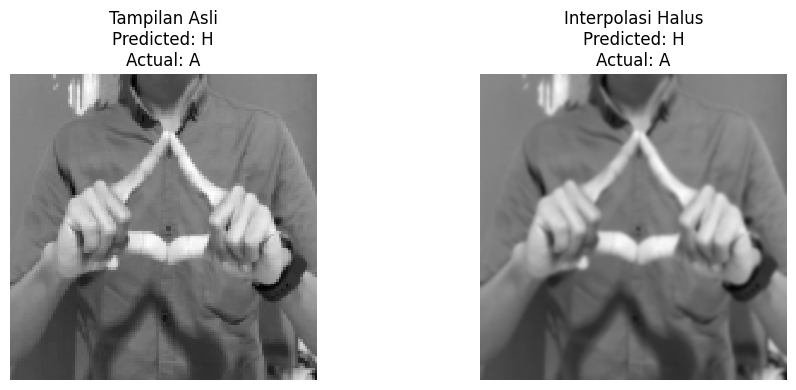

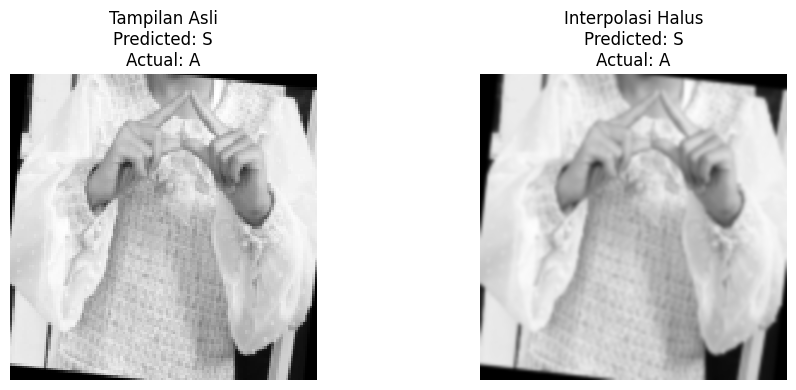

In [186]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# Mapping A-Z untuk plotting
# ---------------------------
letters = [chr(65 + i) for i in range(26)]  # ['A','B',...,'Z']
idx_to_label = {i: l for i, l in enumerate(letters)}

# ---------------------------
# Wrapper dataset untuk evaluasi
# ---------------------------
class EvalDataset(Dataset):
    """
    Wrapper yang membaca sumber data dari dataset asli (dataframe / samples)
    dan mengembalikan (image_tensor, label_int).
    Tujuan: menghindari __getitem__ asli yang mungkin memanggil torch.tensor pada string.
    """
    def __init__(self, base_dataset):
        self.base = base_dataset
        # Coba ambil DataFrame-like (paling umum di implementasi pengguna sebelumnya)
        if hasattr(base_dataset, "data"):
            self.mode = "df"
            self.df = base_dataset.data
        elif hasattr(base_dataset, "dataframe"):
            self.mode = "df"
            self.df = base_dataset.dataframe
        # fallback: list of (path, label) pairs
        elif hasattr(base_dataset, "samples"):
            self.mode = "samples"
            self.samples = base_dataset.samples
        elif hasattr(base_dataset, "imgs"):
            self.mode = "samples"
            self.samples = base_dataset.imgs
        else:
            raise RuntimeError("EvalDataset: tidak menemukan atribut 'data'/'samples'/'imgs' pada dataset asal.")
        # transform dari dataset asli (jika ada)
        self.transform = getattr(base_dataset, "transform", None)

    def __len__(self):
        return len(self.df) if self.mode == "df" else len(self.samples)

    def _path_from_row(self, row):
        # cari kolom path yang umum dipakai
        for key in ("path", "img_path", "image_path", "filename", "file", "img", "image"):
            if key in row.index:
                return row[key]
        # jika tidak ditemukan, coba kolom pertama yang terlihat seperti string path
        for k in row.index:
            v = row[k]
            if isinstance(v, str) and (v.endswith(".jpg") or v.endswith(".png") or "/" in v or "\\" in v):
                return v
        raise RuntimeError("EvalDataset: tidak dapat menemukan kolom path di DataFrame.")

    def _label_from_row(self, row):
        # cari kolom label yang umum
        for key in ("label", "labels", "target", "class"):
            if key in row.index:
                return row[key]
        # fallback: coba kolom kedua (jika format [path, label])
        # (berisiko, tetapi hanya fallback)
        try:
            # ambil elemen non-path pertama
            for k in row.index:
                if k not in ("path", "img_path", "image_path", "filename", "file", "img", "image"):
                    return row[k]
        except Exception:
            pass
        raise RuntimeError("EvalDataset: tidak dapat menemukan kolom label di DataFrame.")

    def _label_to_index(self, label_raw):
        # jika sudah integer
        if isinstance(label_raw, (int, np.integer)):
            return int(label_raw)
        # jika string yang berisi digit
        if isinstance(label_raw, str):
            s = label_raw.strip()
            if s.isdigit():
                return int(s)
            # jika huruf (A..Z)
            ch = s[0].upper()
            if "A" <= ch <= "Z":
                return ord(ch) - 65
            # jika base dataset memiliki mapping class_to_idx
            if hasattr(self.base, "class_to_idx") and isinstance(self.base.class_to_idx, dict):
                if s in self.base.class_to_idx:
                    return int(self.base.class_to_idx[s])
        # terakhir coba cast ke int
        try:
            return int(label_raw)
        except Exception:
            raise ValueError(f"EvalDataset: tidak dapat konversi label: {label_raw!r}")

    def __getitem__(self, idx):
        if self.mode == "df":
            row = self.df.iloc[idx]
            img_path = self._path_from_row(row)
            label_raw = self._label_from_row(row)
        else:
            entry = self.samples[idx]
            # entry biasanya (path, label) atau (path, label, something)
            if isinstance(entry, (list, tuple)) and len(entry) >= 2:
                img_path, label_raw = entry[0], entry[1]
            else:
                raise RuntimeError("EvalDataset: format samples tidak dikenali.")
        # Baca image (gunakan PIL agar kompatibel dengan transform)
        img = Image.open(img_path).convert("L")  # grayscale sesuai kode sebelumnya
        if self.transform:
            img = self.transform(img)
        # konversi label ke integer
        label_idx = self._label_to_index(label_raw)
        return img, torch.tensor(label_idx).long()

# ---------------------------
# Fungsi evaluasi (menggunakan DataLoader baru)
# ---------------------------
def evaluate(model, loader, device):
    model.eval()
    incorrect_samples = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for img, pred, lbl in zip(images, preds, labels):
                if pred != lbl:
                    incorrect_samples.append((img.cpu(), pred.cpu(), lbl.cpu()))
    return incorrect_samples

# ===========================
# Re-initialize model & muat bobot
# ===========================
model = CNN(num_classes=26)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

checkpoint_path = "cnn_handsign_model_70_epoch.pth"
if os.path.exists(checkpoint_path):
    try:
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"✅ Bobot dari checkpoint '{checkpoint_path}' berhasil dimuat untuk evaluasi.")
    except Exception as e:
        print(f"❌ Gagal memuat checkpoint untuk evaluasi: {e}")
else:
    print(f"🔎 Checkpoint '{checkpoint_path}' tidak ditemukan. Evaluasi akan menggunakan model yang tidak terlatih.")

# ===========================
# Buat EvalDataset & eval_loader (mengganti test_loader sementara)
# ===========================
try:
    eval_dataset = EvalDataset(test_loader.dataset)
    batch_size = getattr(test_loader, "batch_size", 32) or 32
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
except Exception as e:
    raise RuntimeError("Gagal membuat eval dataset wrapper. Periksa atribut test_loader.dataset. Error: " + str(e))

# Jalankan evaluasi menggunakan eval_loader
incorrect = evaluate(model, eval_loader, device=device)
print(f"Total prediksi salah: {len(incorrect)}")

# ===========================
# Tampilkan 5 contoh prediksi salah
# ===========================
print("\nMenampilkan 5 contoh prediksi yang salah:")
for i in range(min(5, len(incorrect))):
    img, pred, label = incorrect[i]

    # Konversi tensor image ke array numpy untuk plotting
    img_arr = img.numpy()
    # Jika bernormalisasi ke rentang [-1,1], denormalize asumsi mean=0.5 std=0.5
    if img_arr.min() < -0.1:
        img_arr = img_arr * 0.5 + 0.5

    # Jika channel-first (C,H,W)
    if img_arr.ndim == 3:
        if img_arr.shape[0] == 1:
            img_display = img_arr.squeeze(0)
            is_gray = True
        else:
            img_display = np.transpose(img_arr, (1, 2, 0))
            is_gray = False
    else:
        img_display = img_arr
        is_gray = True

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    if is_gray:
        plt.imshow(img_display, cmap='gray', interpolation='none')
    else:
        plt.imshow(img_display, interpolation='none')
    plt.title(f"Tampilan Asli\nPredicted: {idx_to_label.get(pred.item(), str(pred.item()))}\nActual: {idx_to_label.get(label.item(), str(label.item()))}")
    plt.axis('off')

    plt.subplot(1,2,2)
    if is_gray:
        plt.imshow(img_display, cmap='gray', interpolation='bicubic')
    else:
        plt.imshow(img_display, interpolation='bicubic')
    plt.title(f"Interpolasi Halus\nPredicted: {idx_to_label.get(pred.item(), str(pred.item()))}\nActual: {idx_to_label.get(label.item(), str(label.item()))}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [180]:
# Create the DataFrame `df` by collecting image paths and labels
data = []
for label in label_mapping.keys():
    label_path = os.path.join(PATH_DATASET, "images", "train", label) # Assuming "train" is the subfolder for training data
    if os.path.exists(label_path):
        for fname in os.listdir(label_path):
            full_path = os.path.join(label_path, fname)
            if os.path.isfile(full_path):
                data.append({
                    "label": label_mapping[label],  # Store numerical label
                    "full_path": full_path
                })
    else:
        print(f"Warning: {label_path} not found, skipping.")

df = pd.DataFrame(data)

print(f"Total data points found: {len(df)}")

Total data points found: 9169
